This notebook aims to train and validate the softmax classifier as to compare its performance to that of an LSTM neural network for hate speech classification

# Import Libraries

In [82]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer

from utilities.data_loaders import data_split_metric_values
from utilities.data_preprocessors import read_preprocess, shuffle_data, series_to_1D_array, construct_embedding_dict, construct_embedding_matrix, sentences_to_avgs
from utilities.data_visualizers import train_cross_results_v2, view_final_metrics, multi_class_heatmap, view_metric_values, view_classified_labels
from models.softmax_regression import SoftmaxRegression

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [83]:
# 1 for religious and 0 for non religious
df = pd.read_csv('./data/hate-speech-data-cleaned.csv', index_col=0)
df = shuffle_data(read_preprocess(df))

all_words = pd.Series(series_to_1D_array(df['comment']))
all_unique_words_counts = all_words.value_counts()
all_unique_words = all_words.unique()


In [84]:
df['label'].value_counts()

2    22395
1    21644
0    19743
3     1998
Name: label, dtype: int64

# Preprocess data

In [85]:
# rejoin the comment columns values of lists of words to sentences
df['comment'] = df['comment'].apply(lambda comment: " ".join(comment))
df

,comment,label
0,problem nigger jew something,2
1,say going hard rest ya eye like bitch aint nev...,0
2,truth b told hoe,0
3,got carburetor foyer chevy c rebuilt redneck f...,0
4,plot twist faggot op,2
...,...,...
65775,people dont linch people saying nigger like u ...,1
65776,walking dead gonna trash season,1
65777,one time high school girl told friend needed p...,0
65778,downvote as tranny fluid nothing transvestite,3


In [86]:
# at the same time one hot encode the y labels/classes
# and retrieve the number of unique labels of y
unique_labels = df['label'].unique()
len_unique_labels = len(unique_labels)
Y_oh = one_hot(df['label'], len_unique_labels, dtype=tf.float64).numpy()
Y_oh

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]])

# Retrieving and assigning important variables for training classifier

In [87]:
sents = df['comment']

# get number of all unique words
num_words_3 = len(all_unique_words)

# instantiate Tokenizer on the total number of all unique words
tokenizer = Tokenizer(num_words=num_words_3, split=' ')

# call .fit_on_texts to create the word_index and index_word dicts
tokenizer.fit_on_texts(sents)

# save the tokenizer dictionaries for use later when loading GloVe embeddings
word_to_index = tokenizer.word_index
index_to_word = tokenizer.index_word
print(len(word_to_index))
# print(word_to_index)

47916


In [88]:
# important variables

# includes oov words
emb_dict, emb_vec_len = construct_embedding_dict('./embeddings/glove.42B.300d.txt', word_to_index)
emb_matrix = construct_embedding_matrix(word_to_index, emb_dict, emb_vec_len)

100%|██████████| 47916/47916 [00:00<00:00, 229403.83it/s]


# Transform all sentences to word vectors

In [89]:
vect_sents = sentences_to_avgs(sents, emb_dict)

In [90]:
vect_sents

array([[-1.02720500e-01,  2.07664500e-01, -1.73152500e-01, ...,
         1.54925000e-03,  7.13575000e-02, -1.54447500e-01],
       [-1.09459364e-01,  2.57560458e-01,  3.79000000e-04, ...,
        -2.82171000e-03,  1.81076643e-01,  1.62860479e-01],
       [ 4.57725000e-02,  3.44687500e-01,  1.03723500e-01, ...,
        -1.67512500e-01,  4.95963250e-01,  5.71525000e-02],
       ...,
       [ 5.68865467e-02,  2.03715067e-01, -8.60421867e-02, ...,
         4.48765200e-02,  9.76342200e-02, -1.15391533e-02],
       [-1.68561833e-01,  1.98186333e-01, -3.39048167e-01, ...,
        -2.48214600e-01, -2.22421833e-01, -5.86640000e-02],
       [-2.92442000e-01,  1.77398200e-01, -1.08623200e-01, ...,
        -1.92390600e-01,  2.36959400e-01,  3.12638400e-01]])

In [91]:
vect_sents.shape

(65780, 300)

In [92]:
Y_oh.shape

(65780, 4)

In [93]:
# split data into training, validation, adn testing
train_seqs, _seqs, train_labels, _labels = train_test_split(vect_sents, Y_oh, test_size=0.3, random_state=0)
val_seqs, test_seqs, val_labels, test_labels = train_test_split(_seqs, _labels, test_size=0.5, random_state=0)

In [94]:
train_labels.shape

(46046, 4)

In [95]:
val_labels.shape

(9867, 4)

In [96]:
test_labels.shape

(9867, 4)

In [97]:
Y_oh.dtype

dtype('float64')

In [98]:
vect_sents.dtype

dtype('float64')

In [99]:
model = SoftmaxRegression(train_seqs, train_labels, val_seqs, val_labels, lambda_=0.7)
softmax_history = model.train(show_vars=False)

epoch 0 - train_loss: 122637.6072035705 - train_categorical_accuracy: 37.37% - val_loss: 26526.204043265465 - val_categorical_accuracy: 37.01%
epoch 500 - train_loss: 25654.263623523697 - train_categorical_accuracy: 78.99% - val_loss: 5757.8474924672755 - val_categorical_accuracy: 77.87%
epoch 1000 - train_loss: 25491.06612245699 - train_categorical_accuracy: 79.07% - val_loss: 5730.596464702392 - val_categorical_accuracy: 77.86%
epoch 1500 - train_loss: 25469.28494240531 - train_categorical_accuracy: 79.09% - val_loss: 5727.4886704529235 - val_categorical_accuracy: 77.90%
epoch 2000 - train_loss: 25463.97527139787 - train_categorical_accuracy: 79.11% - val_loss: 5726.779974091145 - val_categorical_accuracy: 77.90%
epoch 2500 - train_loss: 25462.077886772127 - train_categorical_accuracy: 79.13% - val_loss: 5726.869622263603 - val_categorical_accuracy: 77.92%
epoch 3000 - train_loss: 25461.234937211033 - train_categorical_accuracy: 79.12% - val_loss: 5727.182861577463 - val_categorical_

In [100]:
# build the dictionary of results based on metric history of both models
softmax_results = {}
for metric in ['train_loss', 'train_categorical_accuracy', 'val_loss', 'val_categorical_accuracy']:
    if metric not in softmax_results:
        softmax_results[metric] = softmax_history['history'][metric]

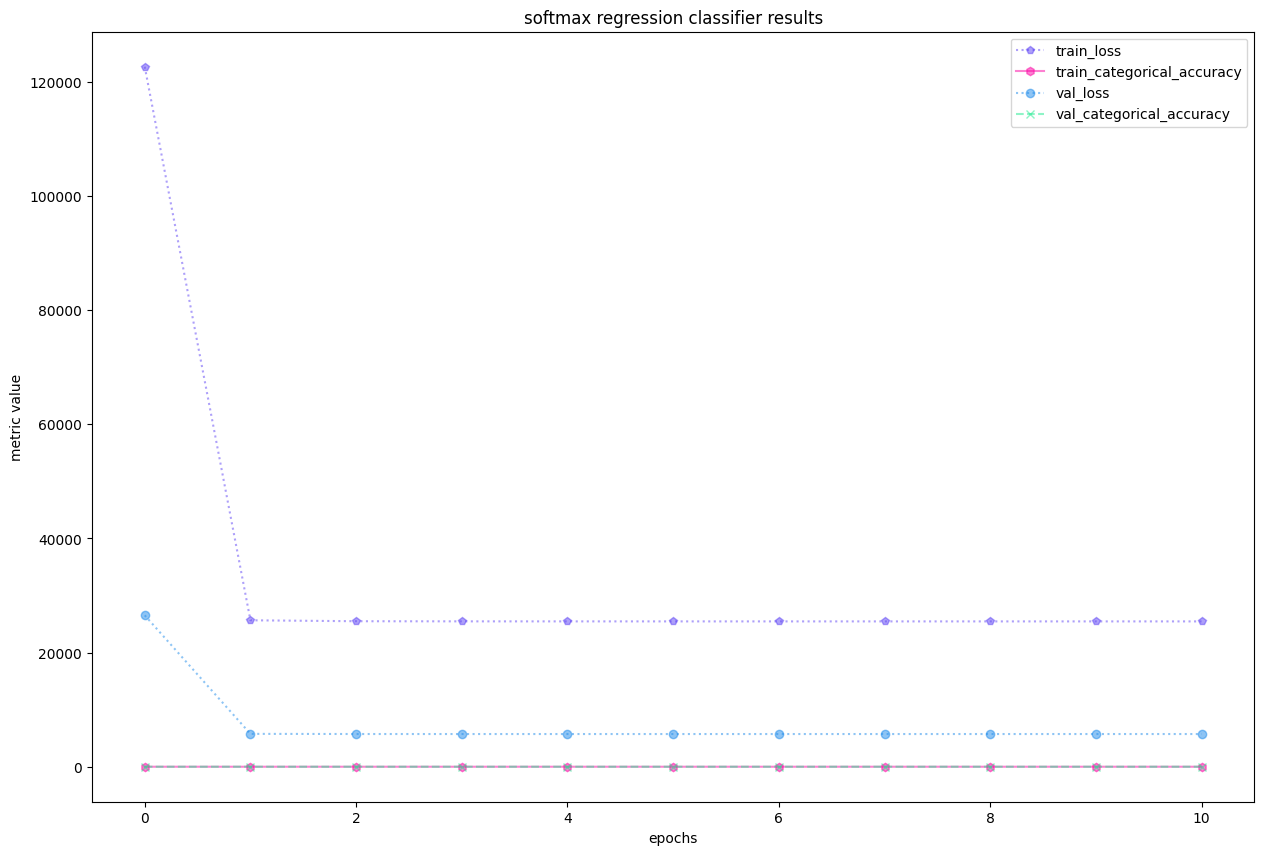

In [101]:
train_cross_results_v2(softmax_results, epochs=softmax_history['epoch'], img_title='softmax regression classifier results')

In [102]:
# display values from last epoch of baseline model
view_final_metrics(softmax_results, 'SOFTMAX REGRESSION CLASSIFIER RESULTS')


SOFTMAX REGRESSION CLASSIFIER RESULTS:
train_loss: 25460.553413835434
train_categorical_accuracy: 0.7911870737957695
val_loss: 5728.03842437139
val_categorical_accuracy: 0.7798723016114321


# Calculating main metric values for training, validation, and testing set e.g. Accuracy, Precision, Recall, F1-Score

In [103]:
# predict probabilities for training set
Y_pred_train = model.predict(train_seqs)
Y_true_train = train_labels.argmax(axis=1)

# predict probabilities for validation set
Y_pred_val = model.predict(val_seqs)
Y_true_val = val_labels.argmax(axis=1)

# predict probabilities for testing set
Y_pred_test = model.predict(test_seqs)
Y_true_test = test_labels.argmax(axis=1)

In [104]:
train_acc, train_prec, train_rec, train_f1 = data_split_metric_values(Y_true_train, Y_pred_train)
val_acc, val_prec, val_rec, val_f1 = data_split_metric_values(Y_true_val, Y_pred_val)
test_acc, test_prec, test_rec, test_f1 = data_split_metric_values(Y_true_test, Y_pred_test)

metrics_df = pd.DataFrame({
    'data_split': ['training', 'validation', 'testing'],
    'accuracy': [train_acc, val_acc, test_acc], 
    'precision': [train_prec, val_prec, test_prec], 
    'recall': [train_rec, val_rec, test_rec], 
    'f1-score': [train_f1, val_f1, test_f1]}, index=["training set", "validation set", "testing set"])

Accuracy: 79.12%
Precision: 79.39%
Recall: 79.12%
F1 score: 79.21%

Accuracy: 77.99%
Precision: 78.29%
Recall: 77.99%
F1 score: 78.08%

Accuracy: 79.07%
Precision: 79.21%
Recall: 79.07%
F1 score: 79.13%



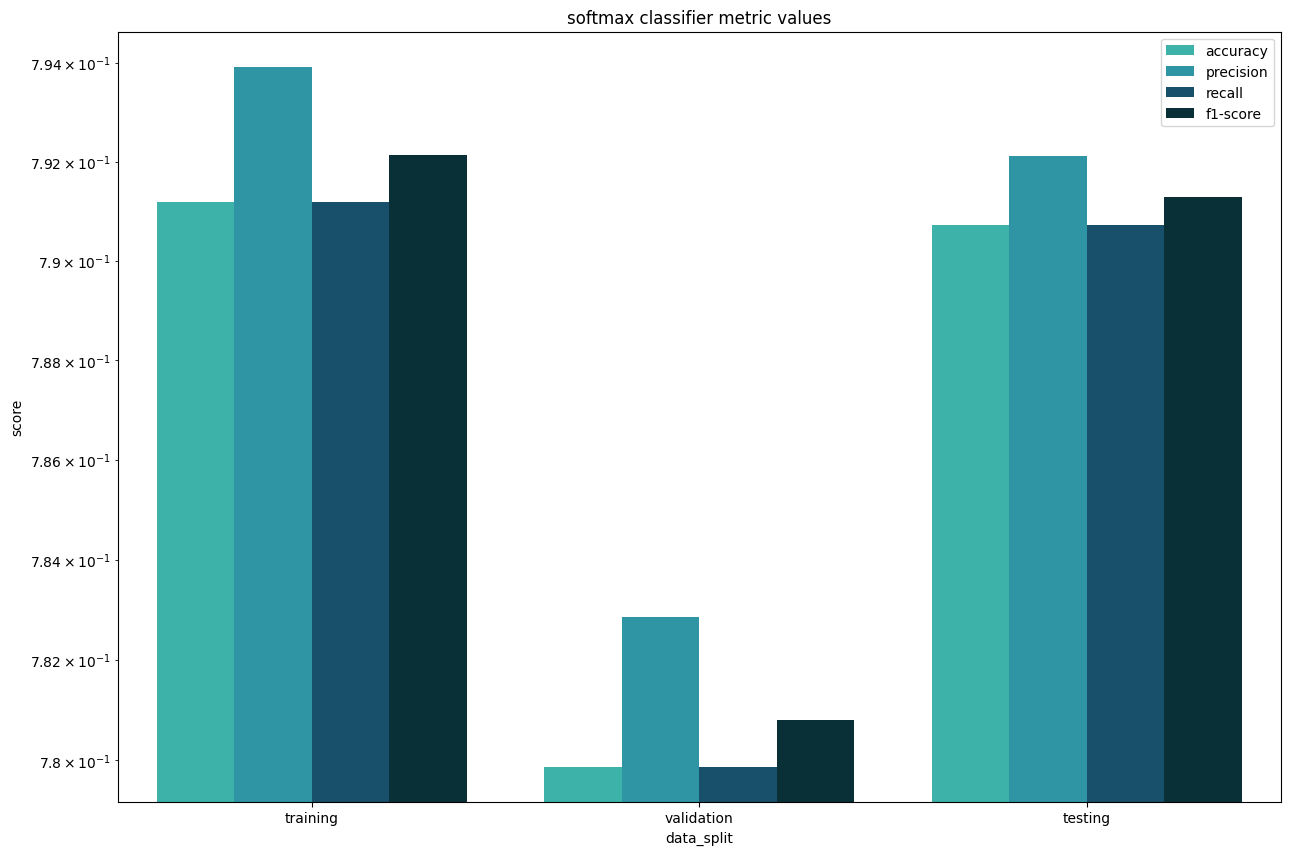

In [105]:
# visualize values of calculated metric value for each data split
view_metric_values(metrics_df, 'softmax classifier metric values')

# Confusion matrices for training, validation, and testing sets

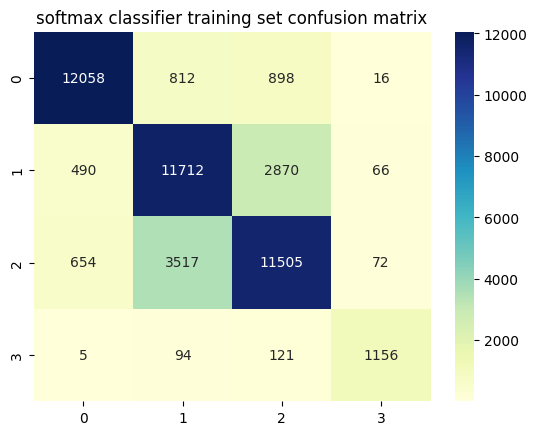

In [106]:
# bug of accuracy precision recall and f1 score being all athe same: https://stackoverflow.com/questions/62792001/precision-and-recall-are-the-same-within-a-model
# In fact in the last three they all give the same example and of course get the same score.
# https://stackoverflow.com/questions/31421413/how-to-compute-precision-recall-accuracy-and-f1-score-for-the-multiclass-case
# https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/

conf_matrix_train = confusion_matrix(Y_true_train, Y_pred_train, labels=np.unique(Y_true_train))
multi_class_heatmap(conf_matrix_train, 'softmax classifier training set confusion matrix')

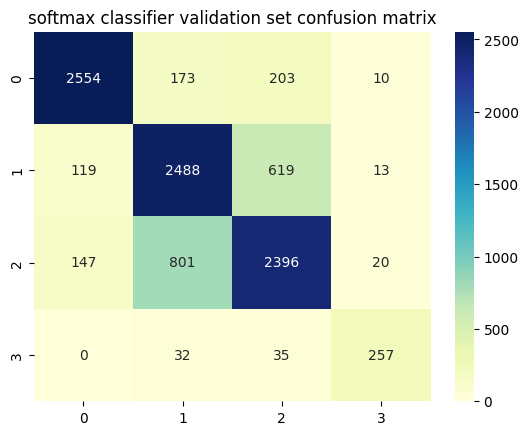

In [107]:
conf_matrix_val = confusion_matrix(Y_true_val, Y_pred_val, labels=np.unique(Y_true_val))
multi_class_heatmap(conf_matrix_val, 'softmax classifier validation set confusion matrix')

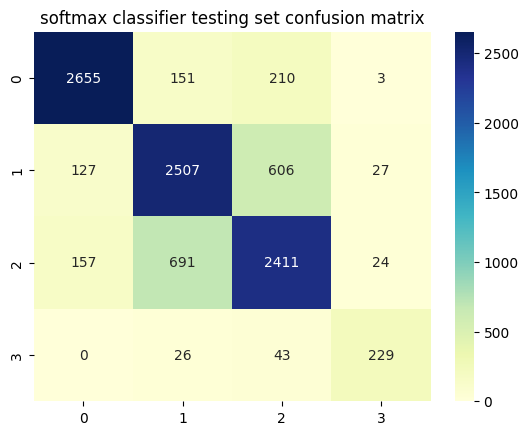

In [108]:

conf_matrix_test = confusion_matrix(Y_true_test, Y_pred_test, labels=np.unique(Y_true_test))
multi_class_heatmap(conf_matrix_test, 'softmax classifier testing set confusion matrix')

In [109]:
# calculating all misclassified vs classified labels for training, validation, and testing sets
num_right_cm_train = conf_matrix_train.trace()
num_right_cm_val = conf_matrix_val.trace()
num_right_cm_test = conf_matrix_test.trace()

num_wrong_cm_train = train_labels.shape[0] - num_right_cm_train
num_wrong_cm_val = val_labels.shape[0] - num_right_cm_val
num_wrong_cm_test = test_labels.shape[0] - num_right_cm_test

classified_df = pd.DataFrame({
    'data_split': ['training', 'validation', 'testing'],
    'classified': [num_right_cm_train, num_right_cm_val, num_right_cm_test], 
    'misclassified': [num_wrong_cm_train, num_wrong_cm_val, num_wrong_cm_test]}, 
    index=["training set", "validation set", "testing set"])

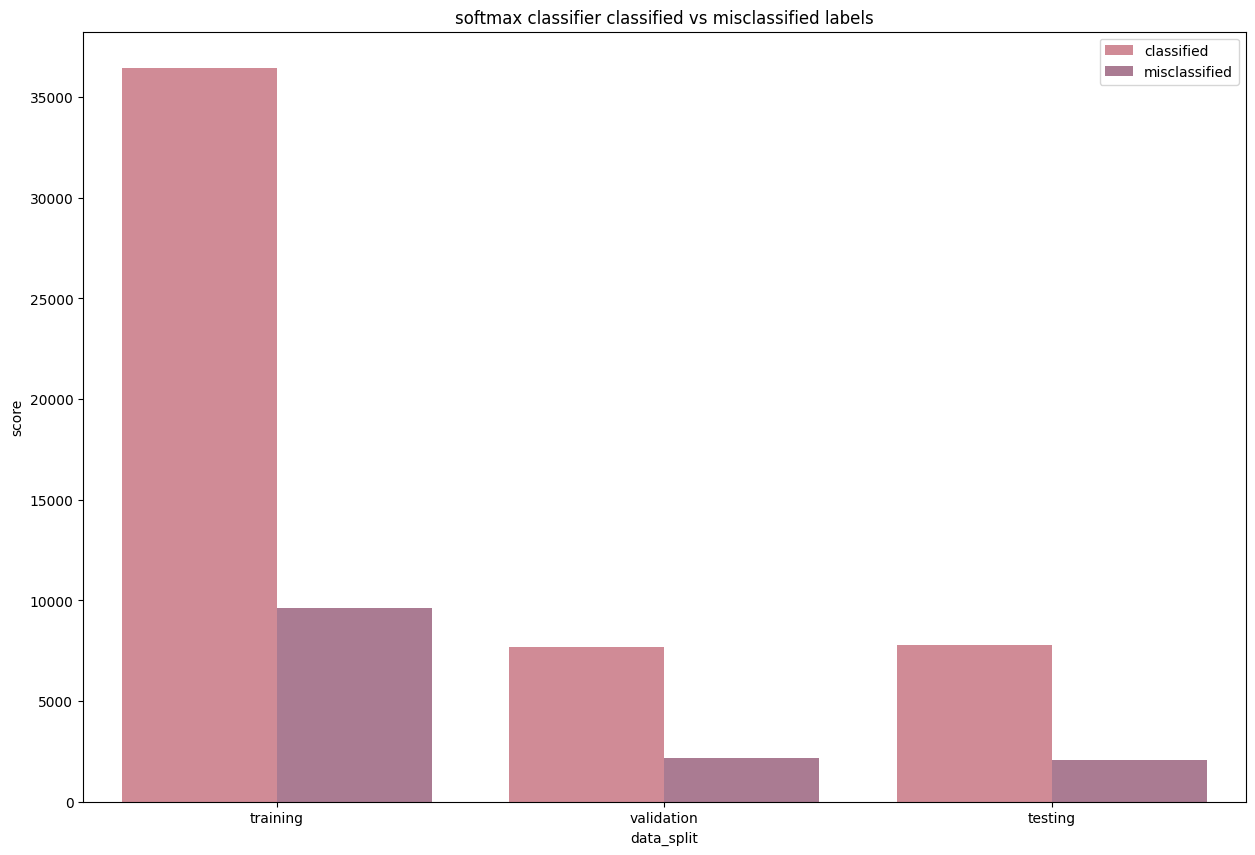

In [110]:
# visualize values of correctly classified labels in each data split
view_classified_labels(classified_df, 'softmax classifier classified vs misclassified labels')

In [111]:
# see the tangible numbers of both classified and misclassified labels for all data splits
print(f'number of correctly classified labels for the training set: {num_right_cm_train}')
print(f'number of correctly classified labels for the validation set: {num_right_cm_val}')
print(f'number of correctly classified labels for the testing set: {num_right_cm_test}')

print(f'number of correctly misclassified labels for the training set: {num_wrong_cm_train}')
print(f'number of correctly misclassified labels for the validation set: {num_wrong_cm_val}')
print(f'number of correctly misclassified labels for the testing set: {num_wrong_cm_test}')

number of correctly classified labels for the training set: 36431
number of correctly classified labels for the validation set: 7695
number of correctly classified labels for the testing set: 7802
number of correctly misclassified labels for the training set: 9615
number of correctly misclassified labels for the validation set: 2172
number of correctly misclassified labels for the testing set: 2065
